In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mopet import mopet

from synchronization import plots
from synchronization import runner
from synchronization import analysis
from synchronization import processing
from synchronization import constants

# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise can lead to synchronization across two networks

## Model Configuration

The default parameters set the model in a state where high noise strength (13.0) synchronized the otherwise desynchronized networks 1 and 2.

In [2]:
params = {
    "runtime": 500.0,

    "J_itoi": 0.4,
    "J_etoe": 0.01,
    "J_etoi": 0.05,
    "J_itoe": 0.2,

    "J_ppee": 0.001,
    "J_ppei": 0.02,
    
    "p_ppee": 1.0,
    "p_ppei": 1.0,
    "p_ppii": 0.0,
    
    "p_etoi": 1.0,
    "p_etoe": 1.0,
    "p_itoe": 1.0,
    "p_itoi": 1.0,

    "ou_enabled": [False, False],

    "poisson_enabled": [True, True],
    "poisson_variance": 1.0,
    "poisson_p": 0.85,
    "poisson_size": 800,
    "poisson_mean_input": 300,
    
    "N_pop": 2,
    
    "net_record_spikes": 400,
    "poisson_I_ratio": 0.4,
    "poisson_I_enabled": True,
     "const_delay": 0.0,
}

## State 3 - Strong Noise - Default - J_ppei and Low J_ppee

In [47]:
params_mid = dict(params)
params_mid.update({
    "poisson_variance": 8.0,
    "runtime": 2000,
    "J_ppee": 0.001,
})

model = runner.run(
    modified_params=params_mid,
    file_name="PING_synch_mechanism",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.11165 s (55%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


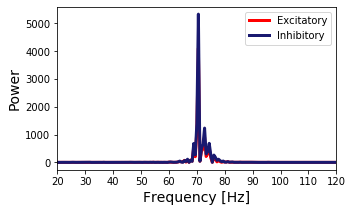

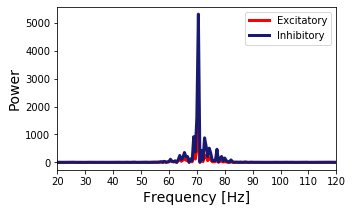

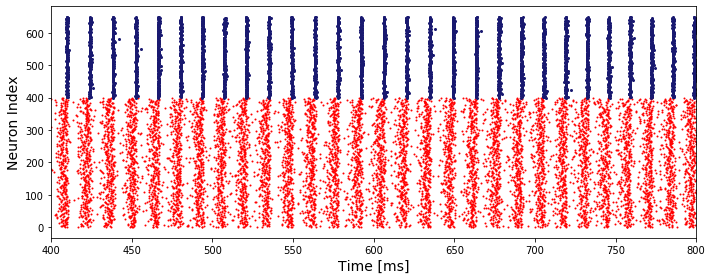

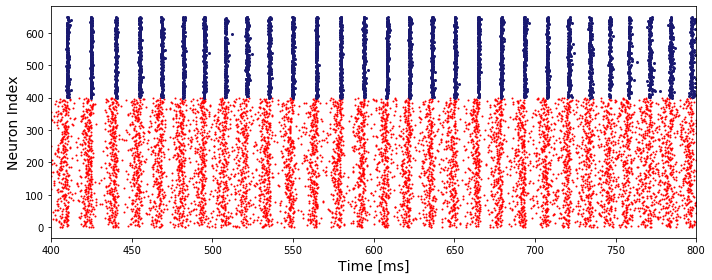

In [48]:
plots.plot_results(model, pop_rates=False, show_lfp=False, x_min_psd=20, x_max_psd=120, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800)

## Strong Noise - Only Input to E Cells

**Result: Input to E cells only is NOT sufficient to induce synchronization!**

In [68]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "poisson_I_enabled": False
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_E",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.17655 s (58%) simulated in 10s, estimated 7s remaining.
2. s (100%) simulated in 16s


In [69]:
model = runner.post_processing(model)

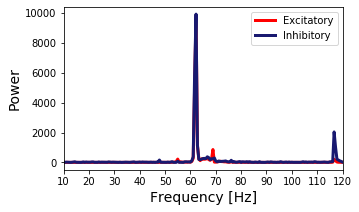

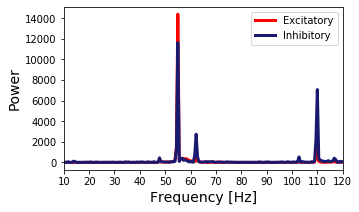

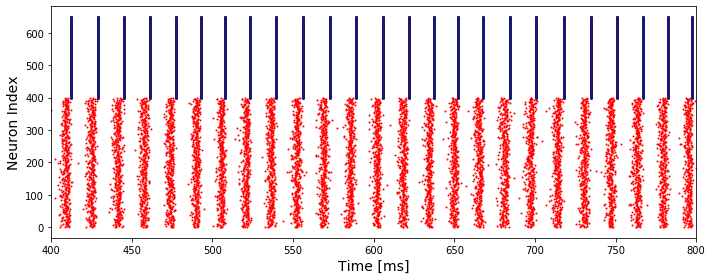

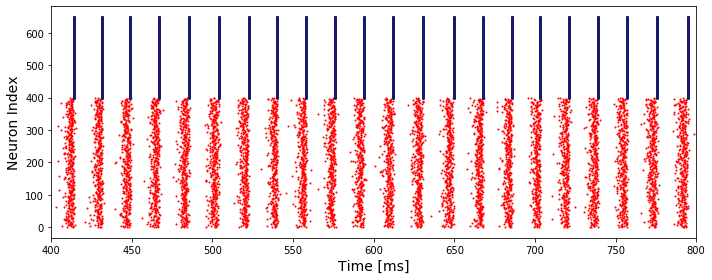

In [70]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

In [75]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 14.0,
     "runtime": 2000,
     "poisson_I_enabled": False
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_E",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.1512 s (57%) simulated in 10s, estimated 7s remaining.
2. s (100%) simulated in 16s


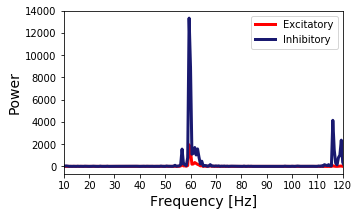

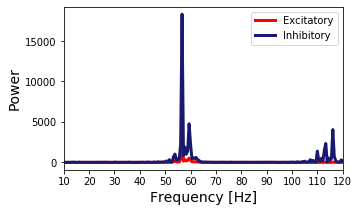

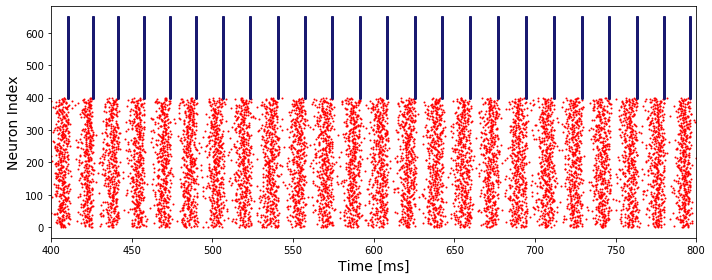

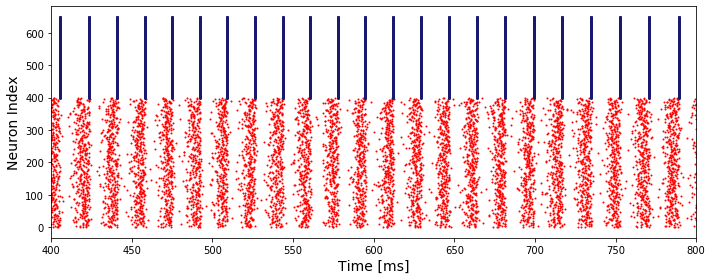

In [76]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800)

In [77]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 18.0,
     "runtime": 2000,
     "poisson_I_enabled": False
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_E",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.30755 s (65%) simulated in 10s, estimated 5s remaining.
2. s (100%) simulated in 15s


In [80]:
model = runner.post_processing(model)

Global Order Parameter value of: 0.5683966829219371
Mean Phase Coherence 0.6064372207631832
plv_net_1:  0.2254909064345549
plv_net_1_i:  0.9999999050340228
plv_net_2:  0.339233838561118
plv_net_2_i:  0.9999999996739014
plv_net_1_e:  0.32091070887212464
plv_net_2_e:  0.33382386261867536
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.22551938348784278
Within Synchronization of Network 2 0.3396605841631737


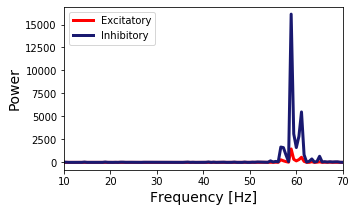

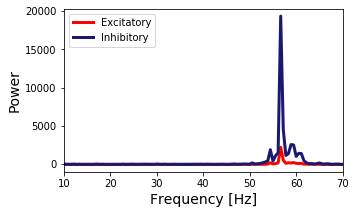

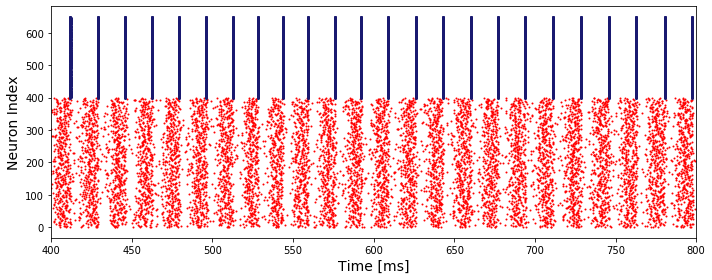

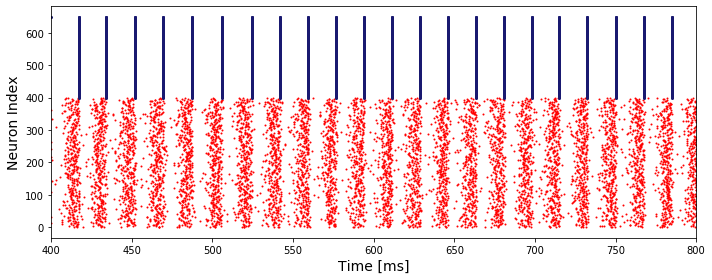

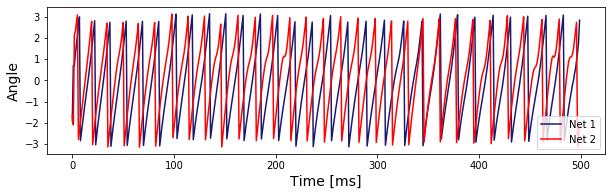

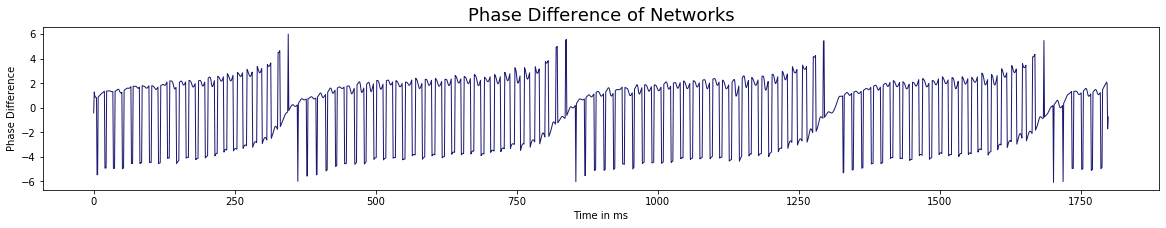

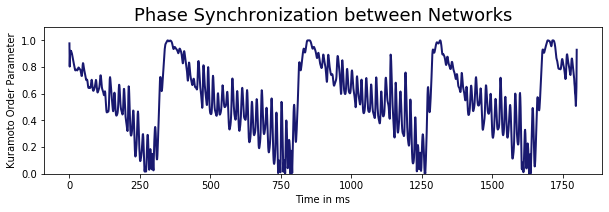

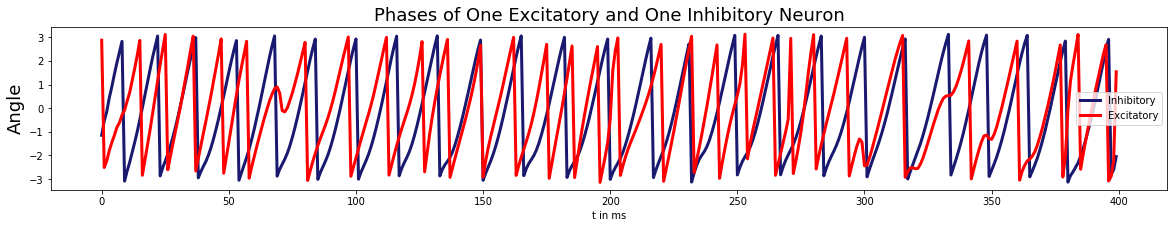

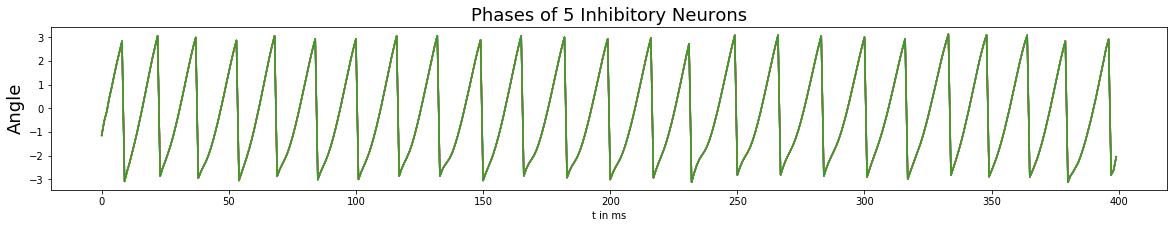

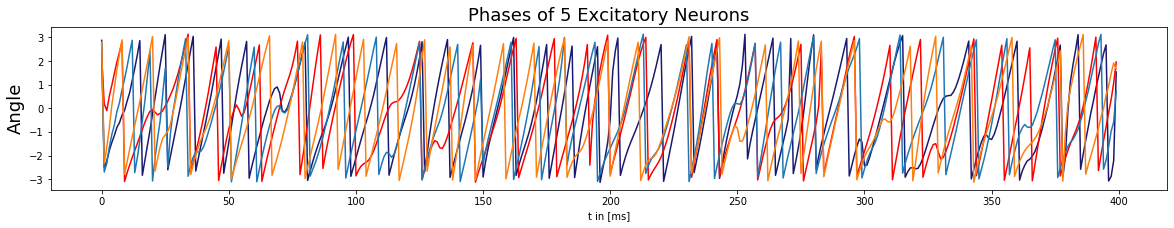

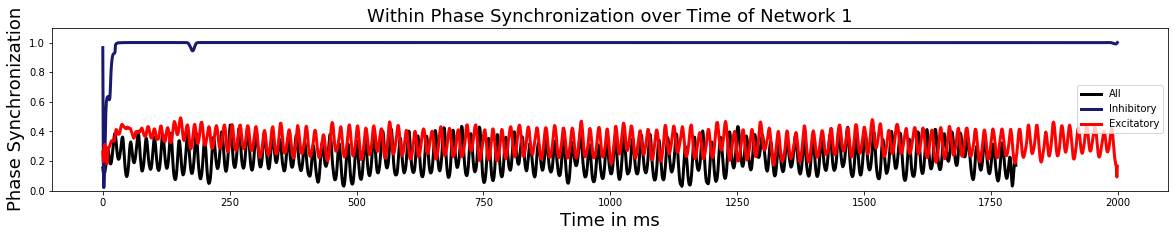

In [82]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, x_max_psd=70, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=True)

In [ ]:
exp_params = {
    "poisson_variance": np.arange(1.0, 10.0, 1.0),
    "poisson_p": np.arange(0.8, 1.0, 0.05),
}

ov_params = dict(params)
ov_params.update({
    "runtime": 2000
})

ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=exp_params, 
    default_params=ov_params,
    hdf_filename=constants.MODELS_PATH + "/PING_input_to_E.h5",
    exploration_name="exp_1"
)

In [ ]:
ex.run()

In [ ]:
ex.load_results(all=True)

In [ ]:
plots.plot_exploration(ex, vmin_ratio=None)

## Strong Noise - Only J_ppei connection

**Result: The E -> I Connection between Networks is the key strength to synchronization**

In [41]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "J_ppee": 0.0
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppei",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.1249 s (56%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


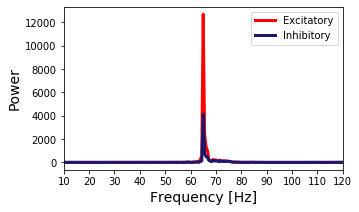

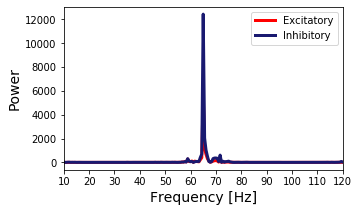

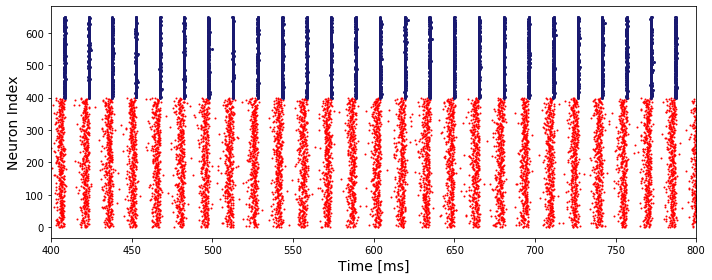

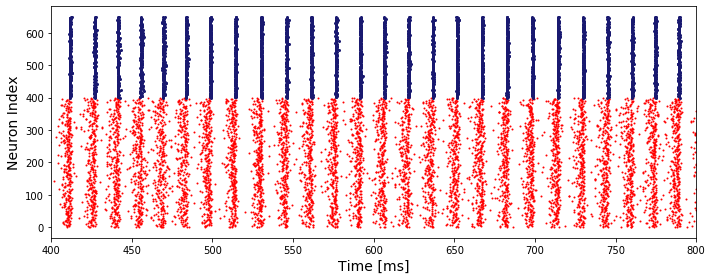

In [42]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

In [64]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "J_ppee": 0.0,
     "J_ppei": 0.05,
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppei",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.10275 s (55%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


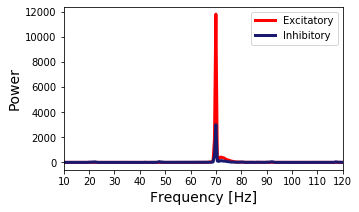

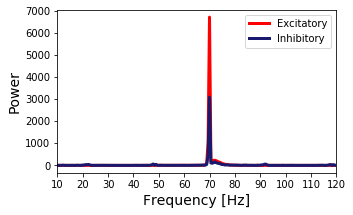

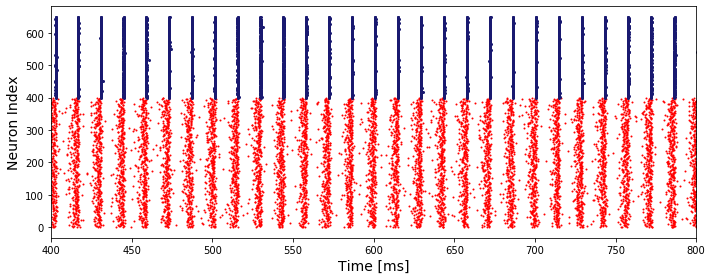

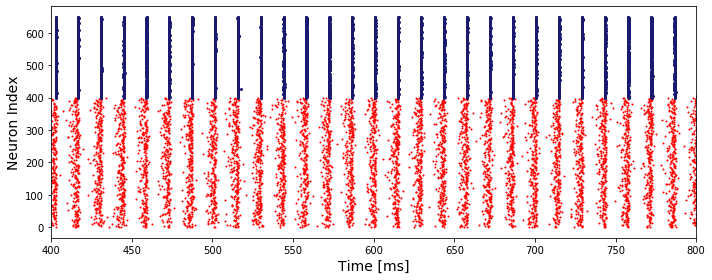

In [65]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

In [66]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "J_ppee": 0.0,
     "J_ppei": 0.1,
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppei",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.18225 s (59%) simulated in 10s, estimated 7s remaining.
2. s (100%) simulated in 16s


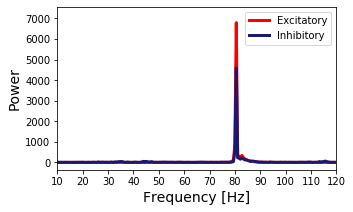

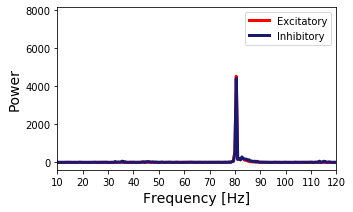

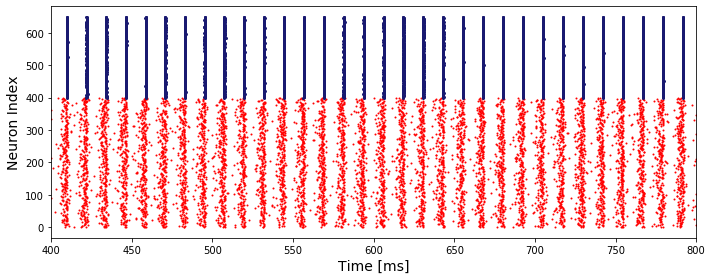

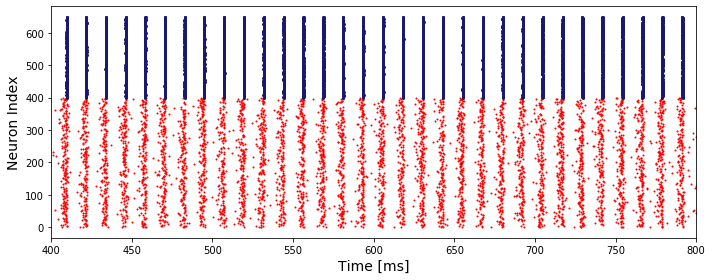

In [67]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

## Strong Noise - only J_ppee connection

TODO: check synchronization between networks if frequencies match.
E1 <-> E2 und I1 <-> I2

In [88]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 1.0,
     "runtime": 2000,
     "J_ppee": 0.02,
     "J_ppei": 0.0
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppee",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.05885 s (52%) simulated in 10s, estimated 9s remaining.
2. s (100%) simulated in 18s


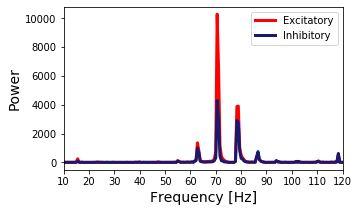

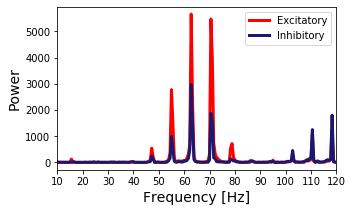

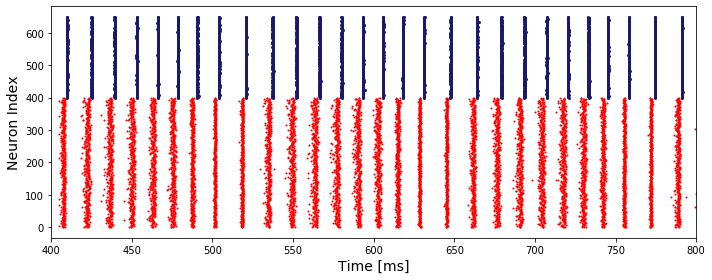

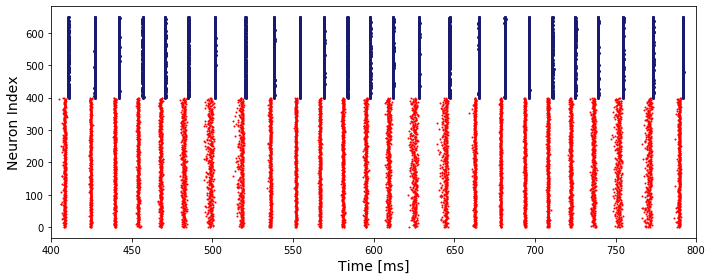

In [89]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

In [95]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 2.0,
     "runtime": 2000,
     "J_ppee": 0.02,
     "J_ppei": 0.0
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppee",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.13675 s (56%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


In [96]:
model = runner.post_processing(model)

Global Order Parameter value of: 0.6043829333341496
Mean Phase Coherence 0.19971322728926832
plv_net_1:  0.5525760753149352
plv_net_1_i:  0.9234228446978174
plv_net_2:  0.6278683256276382
plv_net_2_i:  0.9621931288616525
plv_net_1_e:  0.8142984396436919
plv_net_2_e:  0.8713653285839725
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.5517404842214744
Within Synchronization of Network 2 0.6304742373211866


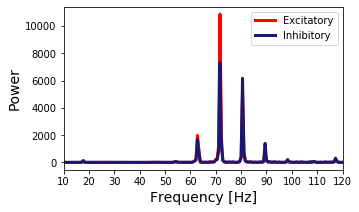

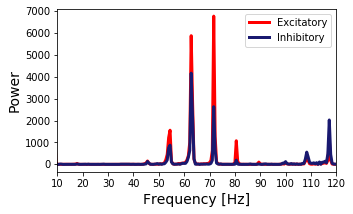

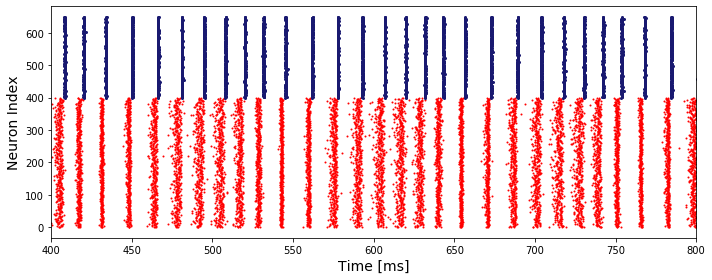

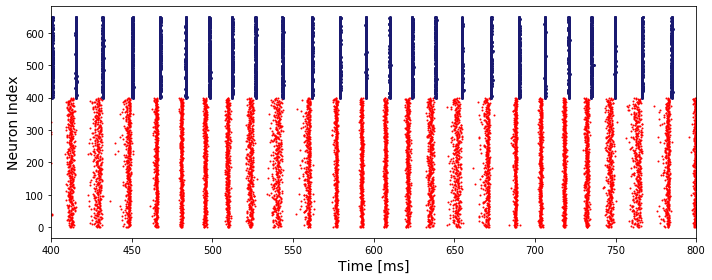

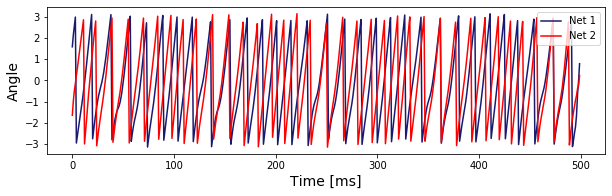

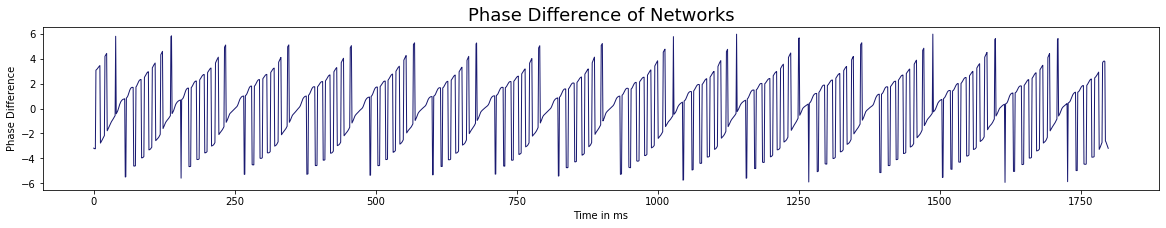

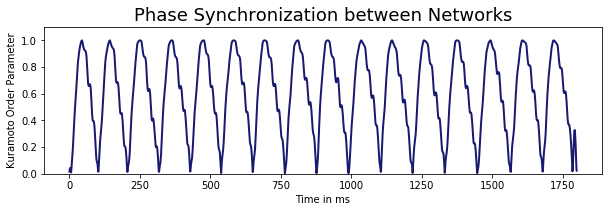

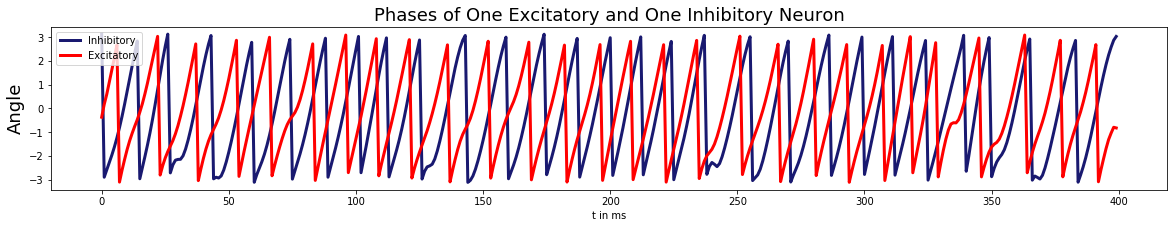

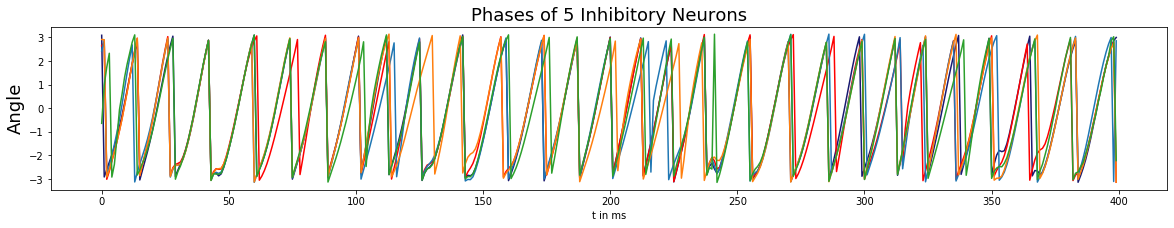

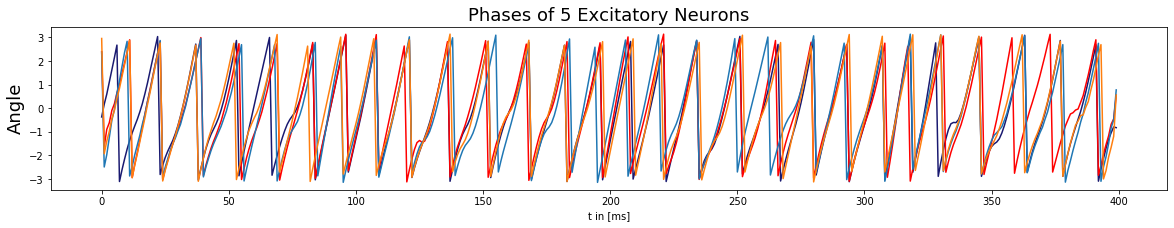

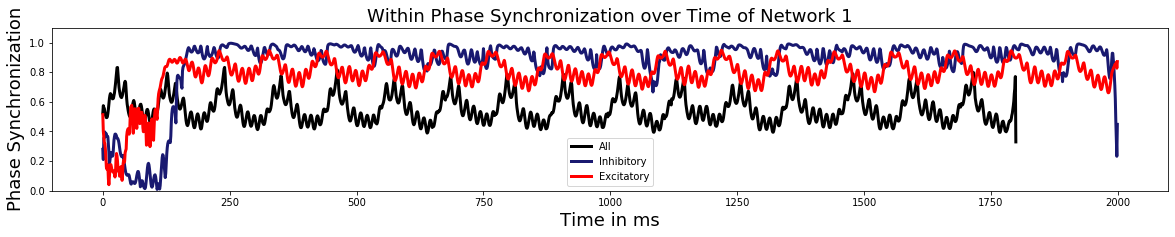

In [97]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=True)

In [98]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "J_ppee": 0.02,
     "J_ppei": 0.0
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppee",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.11745 s (55%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


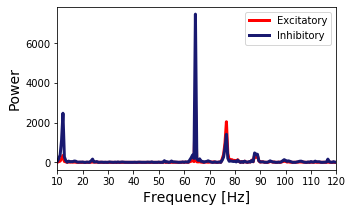

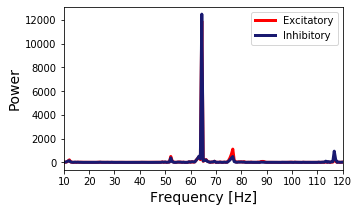

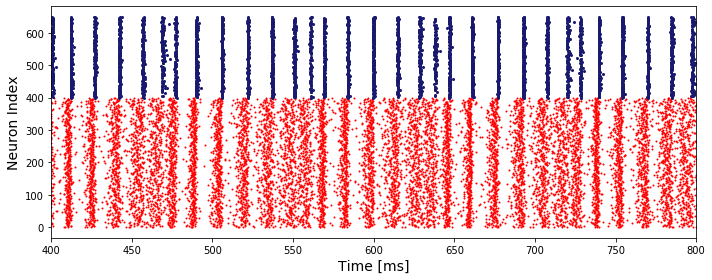

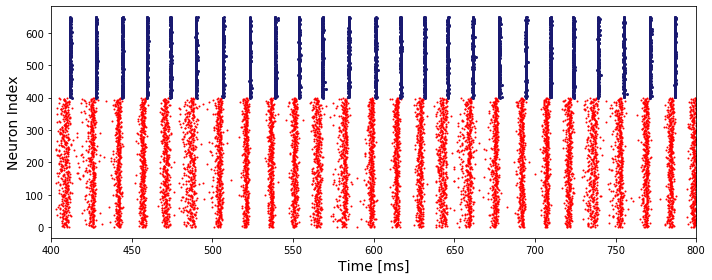

In [99]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

In [100]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 8.0,
     "runtime": 2000,
     "J_ppee": 0.02,
     "J_ppei": 0.0
})

model = runner.run(
    modified_params=params_mod,
    file_name="PING_noise_only_J_ppee",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.12515 s (56%) simulated in 10s, estimated 8s remaining.
2. s (100%) simulated in 17s


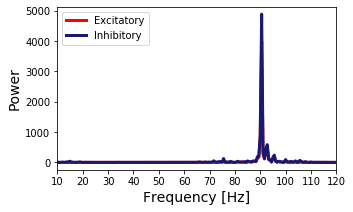

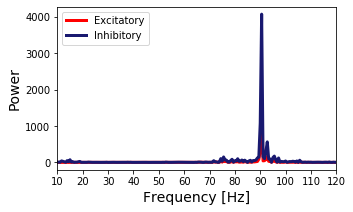

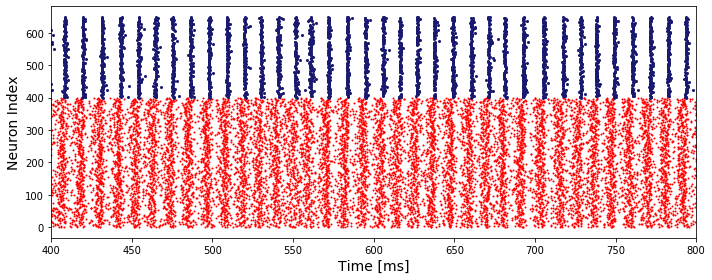

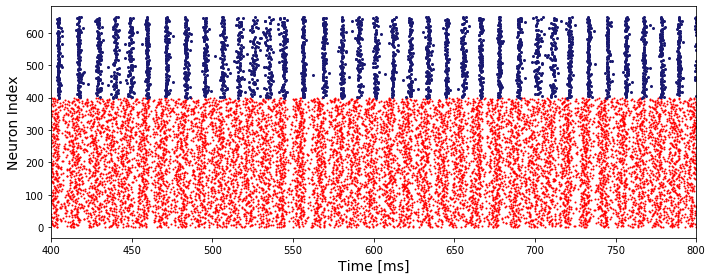

In [101]:
plots.plot_results(model, pop_rates=False, show_lfp=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800, phase_analysis=False)

## Strong Noise - J_ppei with increased J_ppee

In [52]:
params_mod = dict(params)
params_mod.update({
     "poisson_variance": 4.5,
     "runtime": 2000,
     "J_ppee": 0.05,
     "J_ppei": 0.02
})

model = runner.run(
    modified_params=params_mod,
#     file_name="PING_noise_only_J_ppee",
    load=False
)

Starting simulation at t=0. s for a duration of 2. s
1.06145 s (53%) simulated in 10s, estimated 9s remaining.
2. s (100%) simulated in 18s


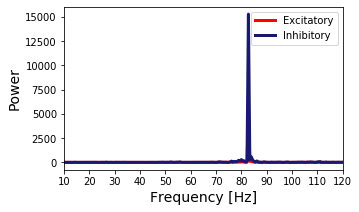

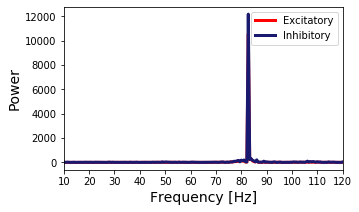

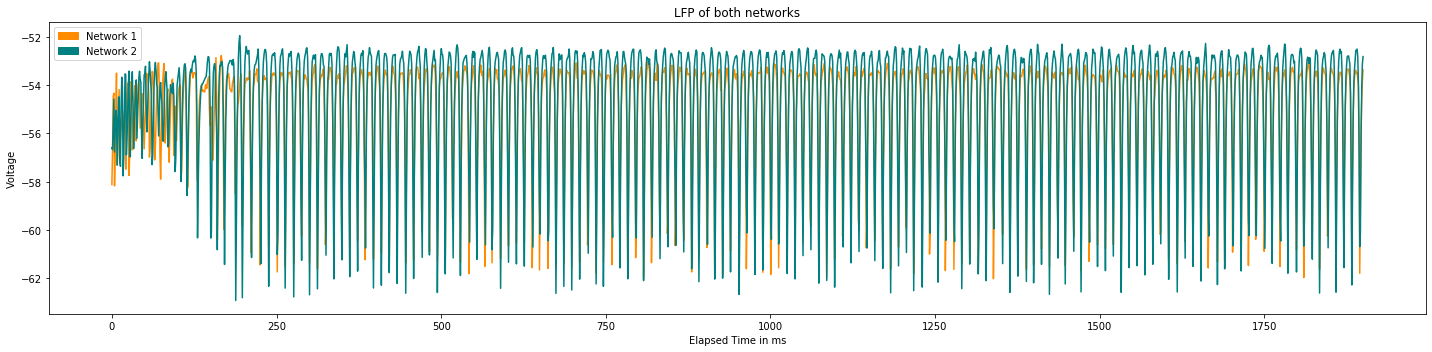

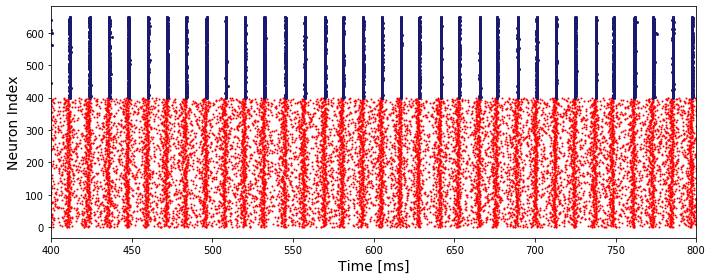

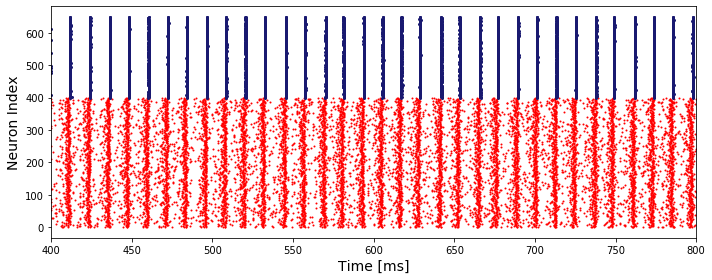

In [53]:
plots.plot_results(model, pop_rates=False, raster_right=2000, excerpt_x_left=400, excerpt_x_right=800)

# Phase Circular Distribution

NameError: name 'avg' is not defined

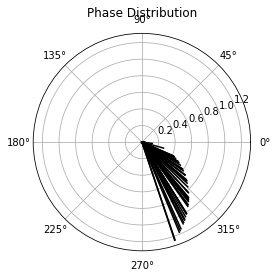

In [32]:
# TODO: fix this
# We want to plot here the average phase angle vectors of each neuron on the polar axis

phases = processing.phase(f_neurons_net_1)

plt.axes(polar=True)
plt.title("Phase Distribution")

for angle in phases[:50]:
    plt.plot((0, angle[10]), (0, np.abs(angle[10])), c="black")

# plot the average phase vector
# length of vector expresses the synchronization, [0-1].
plt.plot((0, avg[10]), (0, phi[10]), c='red')
plt.show()